# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
trans_df = pd.read_csv('../data/credit_card_fraud_data_v2.csv')

In [3]:
trans_df.shape

(6372620, 11)

In [34]:
trans_df.columns

Index(['Time_Stamp', 'Transaction_Type', 'Amount', 'Client_Id',
       'Client_Old_Balance', 'Cleint_New_Balance', 'Merchant_Id',
       'Merchant_Old_Balance', 'Merchant_New_Balance', 'Is_Fraud',
       'Is_Flagged_Fraud'],
      dtype='object')

In [35]:
trans_df.head()

,Time_Stamp,Transaction_Type,Amount,Client_Id,Client_Old_Balance,Cleint_New_Balance,Merchant_Id,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Is_Flagged_Fraud
0,1,BILL-PAYMENT,9839.64,C494672677,170136.0,160296.36,M582455116,0.0,0.0,0,0
1,1,BILL-PAYMENT,1864.28,C502607876,21249.0,19384.72,C214000796,0.0,0.0,0,0
2,1,PURCHASE,181.00,C633112680,181.0,0.00,M1922059099,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C1993768127,181.0,0.00,M245426835,21182.0,0.0,1,0
4,1,BILL-PAYMENT,11668.14,C1445837831,41554.0,29885.86,M1368211346,0.0,0.0,0,0


In [277]:
trans_df = pd.get_dummies(trans_df, columns=['Transaction_Type'])

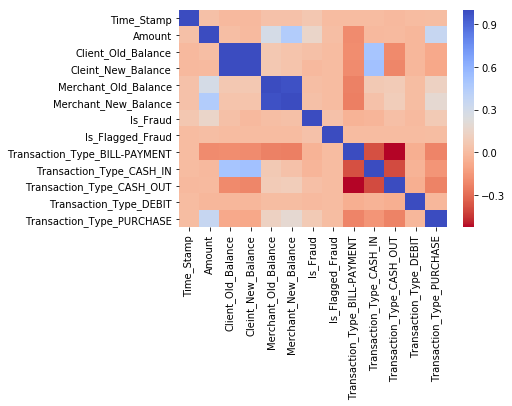

In [278]:
corr = trans_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.savefig('feature_correlation')
plt.show()

In [274]:
trans_df['Transaction_Type'].unique()

array(['BILL-PAYMENT', 'PURCHASE', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

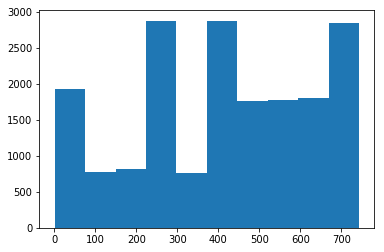

In [172]:
# Histogram of time stamps of fraud transactions
plt.hist(trans_df[trans_df.Is_Fraud == 1].Time_Stamp)
plt.show()

In [22]:
trans_df['Time_Stamp'].max()

743

### How different is Balance Difference and Amount? 

In [137]:
bal_diff = trans_df['Client_Old_Balance'] - trans_df['Cleint_New_Balance']
bal_diff = bal_diff.abs()

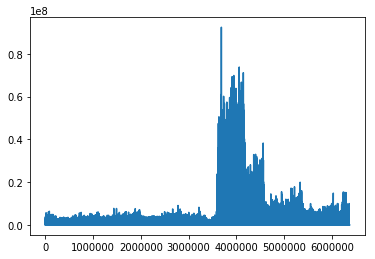

In [175]:
column_diff = (bal_diff - trans_df.Amount).abs()
plt.plot(column_diff)
plt.show()

### Number of Fraud cases that are Flagged

In [ ]:
trans_df.Is_Fraud[trans_df.Is_Flagged_Fraud == 1].sum()

### Number of Fraud Cases: 0.3 % !!!!!

In [7]:
trans_df['Is_Fraud'].sum()

18213

### Number of Unique Clients

In [8]:
trans_df['Client_Id'].unique().shape

(952147,)

### Number of Unique Merchants

In [9]:
trans_df['Merchant_Id'].unique().shape

(522360,)

### Range of Trans. Amount Values

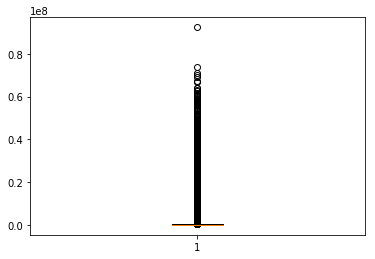

In [11]:
plt.boxplot(trans_df['Amount'])
plt.show()

In [13]:
trans_df['Amount'].max()

92445516.64

In [14]:
trans_df['Amount'].min()

0.0

In [16]:
np.sum(np.abs(trans_df['Is_Fraud'].values - trans_df['Is_Flagged_Fraud'].values))

18197

In [18]:
trans_df['Is_Flagged_Fraud'].sum()

16

### Transaction Type When Fraud

In [272]:
fraud_trans = trans_df[trans_df.Is_Fraud == 1]['Transaction_Type']

In [273]:
fraud_trans.unique()

array(['PURCHASE', 'CASH_OUT'], dtype=object)

In [19]:
np.sum(fraud_trans == 'CASH_OUT')

9116

In [20]:
np.sum(fraud_trans == 'PURCHASE')

9097

### Amount Range When Fraud

In [270]:
amount_fraud = trans_df[trans_df.Is_Fraud == 1]['Amount']

In [271]:
amount_fraud.max()

10000000.0

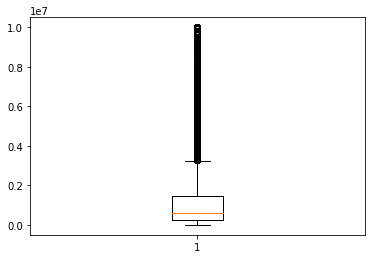

In [171]:
plt.boxplot(amount_fraud)
plt.show()

# Undersample majority class for balanced dataset

In [4]:
nonfraud_trans = trans_df[trans_df.Is_Fraud == 0]
fraud_trans = trans_df[trans_df.Is_Fraud == 1]

In [5]:
nonfraud_trans_idxs = np.random.choice(nonfraud_trans.index, fraud_trans.shape[0], replace=False)
nonfraud_trans = nonfraud_trans.loc[nonfraud_trans_idxs]

X = pd.concat([nonfraud_trans, fraud_trans])
X = X.sample(frac=1).reset_index(drop=True)

In [6]:
X.shape

(36426, 11)

In [39]:
X.to_csv("undersampled_df")

# Feature Engineering

3 engineered features:
- Abs client bal diff
- Abs merchant ball diff
- Amount % of old bal

With engineered features: 
- RLR: .96 acc, .99 AUC
- SVM: 0.87, 0.99
- RF: 0.99, 0.99
- KNN: 0.97, 0.99

Remove "Abs client bal diff":
- RLR:  0.96 acc,  0.99 AUC
- SVM: 0.87, 0.97
- RF: 0.97, 0.99
- KNN: 0.97, 0.99

Remove "Abs merchant bal diff":
- RLR: 0.96, 0.99 
- SVM: 0.87, 0.98
- RF: 0.99, 0.99
- KNN: 0.97, 0.99

Remove "Amount % of old bal":
- RLR: 0.96, 0.99
- SVM: 0.85, 0.97
- RF: 0.97, 0.99
- KNN: 0.97, 0.99

In [7]:
X = pd.read_csv('undersampled_df').drop(columns=['Unnamed: 0'])

In [8]:
# Change Trans Type to one-hot encoding
model_data = pd.get_dummies(X, columns=['Transaction_Type'])

# Remove columns that don't matter
model_data = model_data.drop(columns=['Time_Stamp', 'Client_Id', 'Merchant_Id', 'Is_Flagged_Fraud'])

In [9]:
# Create new feature 
old_bal = model_data.Client_Old_Balance
purch_amt = model_data.Amount
pctg_bal = purch_amt / old_bal

# Add new feature column
model_data['%_Of_Balance'] = pctg_bal

# Remove rows where %_of_Balance == inf
model_data = model_data[model_data['%_Of_Balance'] != np.inf]

In [10]:
# Combine client balance into one 
bal_diff = model_data.Cleint_New_Balance - model_data.Client_Old_Balance

# Add new feature column
model_data['client_bal_diff'] = bal_diff

# Remove columns
model_data = model_data.drop(columns=['Cleint_New_Balance', 'Client_Old_Balance'])

In [11]:
# Combine merchant balance into one 
bal_diff = model_data.Merchant_New_Balance - model_data.Merchant_Old_Balance

# Add new feature column
model_data['merch_bal_diff'] = bal_diff

# Remove columns
model_data = model_data.drop(columns=['Merchant_New_Balance', 'Merchant_Old_Balance'])

In [12]:
model_data.shape

(30426, 10)

In [13]:
model_data.dropna(inplace=True)

In [14]:
model_data.shape

(30410, 10)

# Split Data into Train/Test

In [15]:
y = model_data.Is_Fraud
X = model_data.drop(columns=['Is_Fraud'])

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22807, 9), (22807,), (7603, 9), (7603,))

In [17]:
X_train.columns

Index(['Amount', 'Transaction_Type_BILL-PAYMENT', 'Transaction_Type_CASH_IN',
       'Transaction_Type_CASH_OUT', 'Transaction_Type_DEBIT',
       'Transaction_Type_PURCHASE', '%_Of_Balance', 'client_bal_diff',
       'merch_bal_diff'],
      dtype='object')

In [18]:
# Standardize non-binary columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# X_train[['Amount', 'client_bal_diff', 'merch_bal_diff', '%_Of_Balance']]
# model_data['Amount'] = (model_data.Amount - model_data.Amount.mean())/model_data.Amount.std()
# model_data['client_bal_diff'] = (model_data.client_bal_diff - model_data.client_bal_diff.mean())/model_data.client_bal_diff.std()
# model_data['merch_bal_diff'] = (model_data.merch_bal_diff - model_data.merch_bal_diff.mean())/model_data.merch_bal_diff.std()
# model_data['%_Of_Balance'] = (model_data['%_Of_Balance'] - model_data['%_Of_Balance'].mean())/model_data['%_Of_Balance'].std()


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Run Basic Logistic Regression 

In [19]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_validate

model = LogisticRegressionCV(penalty='l2', cv=5)
model = model.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

In [20]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, confusion_matrix

In [21]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

0.994893609211119

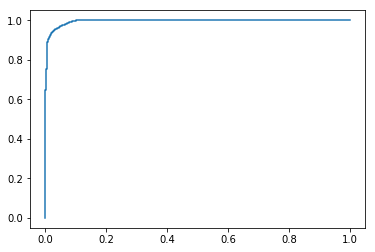

In [22]:
# Plot ROC Curve
fpr, tpr, thres = roc_curve(y_test, y_pred[:,1])
plt.plot(fpr, tpr)
plt.show()

In [23]:
model.score(X_test, y_test)

0.9619886886755228

In [24]:
y_hat = model.predict(X_test)
f1_score(y_test, y_hat)

0.9680909793529866

In [29]:
RLR_interpret = pd.DataFrame(data={'Features': X.columns, 'Coeffs': model.coef_[0]})

In [30]:
RLR_interpret.sort_values(by='Coeffs', ascending=False)

,Features,Coeffs
5,Transaction_Type_PURCHASE,19.358252
3,Transaction_Type_CASH_OUT,17.527432
4,Transaction_Type_DEBIT,-0.715856
0,Amount,-1.202229
1,Transaction_Type_BILL-PAYMENT,-1.563326
2,Transaction_Type_CASH_IN,-4.279359
7,client_bal_diff,-315.752161
8,merch_bal_diff,-334.310085
6,%_Of_Balance,-346.534249


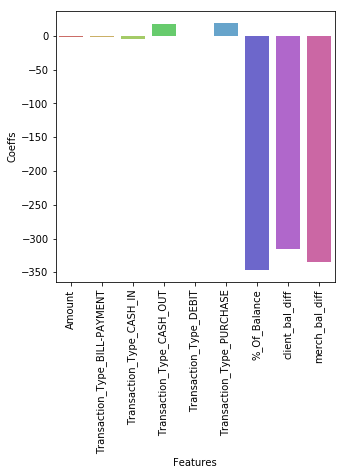

In [35]:
plt.figure(figsize=(5,5))
sns.barplot(x="Features", y="Coeffs", data=RLR_interpret, palette='hls')
plt.xticks(rotation=90)
plt.show()

# SVM using RBF Kernel

In [218]:
from sklearn.svm import SVC

In [219]:
svm_model = SVC(probability=True)
svm_model = svm_model.fit(X_train, y_train)

/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [220]:
y_pred = svm_model.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

0.9723928824430921

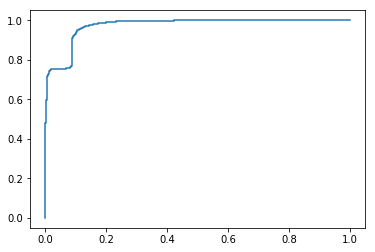

In [221]:
# Plot ROC Curve
fpr, tpr, thres = roc_curve(y_test, y_pred[:,1])
plt.plot(fpr, tpr)
plt.show()

In [222]:
svm_model.score(X_test, y_test)

0.8459426814538267

In [223]:
y_hat = svm_model.predict(X_test)
f1_score(y_test, y_hat)

0.8340626848018924

# Random Forest 

In [244]:
from sklearn.ensemble import RandomForestClassifier

In [245]:
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train)

/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


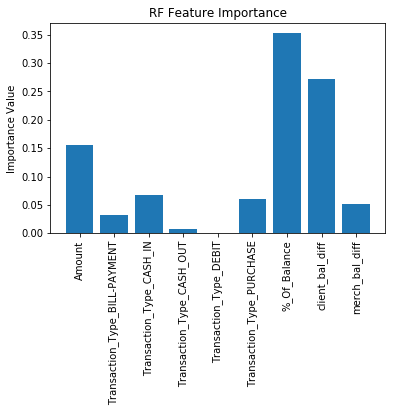

In [268]:
plt.bar(X.columns, rf_model.feature_importances_)
plt.xticks(rotation=90)
plt.ylabel("Importance Value")
plt.title("RF Feature Importance")
plt.savefig('RF_feature_importance')
plt.gcf().subplots_adjust(bottom=0.15)
plt.show()

In [226]:
y_pred = rf_model.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

0.9892261236887148

In [227]:
rf_model.score(X_test, y_test)

0.9705720874052927

In [228]:
y_hat = rf_model.predict(X_test)
f1_score(y_test, y_hat)

0.9703277236492471

In [229]:
confusion_matrix(y_test, y_hat)

array([[4457,  119],
       [ 149, 4382]])

# KNN 

In [230]:
from sklearn.neighbors import KNeighborsClassifier

In [231]:
num_nbrs = [5, 10, 15, 20, 25, 30]

for k in num_nbrs:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model = knn_model.fit(X_train, y_train)
    acc = knn_model.score(X_test, y_test)
    y_pred = knn_model.predict(X_test)
    y_pred_prob = knn_model.predict_proba(X_test)
    print("k={0}, acc: {1}, f1-score: {2}, auc: {3}".format(k, acc, f1_score(y_test, y_pred), 
                                                            roc_auc_score(y_test, y_pred_prob[:,1])))

k=5, acc: 0.9729878115735149, f1-score: 0.9729848451570393, auc: 0.9930993781378631
k=10, acc: 0.9724387833534643, f1-score: 0.972426672525541, auc: 0.9953782354811377
k=15, acc: 0.974195673657626, f1-score: 0.974375749645622, auc: 0.9959152074751555
k=20, acc: 0.974195673657626, f1-score: 0.9743589743589743, auc: 0.9962813477628087
k=25, acc: 0.9744152849456462, f1-score: 0.9746711599086857, auc: 0.9964355641324025
k=30, acc: 0.9733172285055451, f1-score: 0.9735553379040157, auc: 0.9964896785238597
